# Factor Analysis for FX Carry

## Magic

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import polars as pl
import plotnine as p9

p9.options.figure_size = (8, 5)

## Data Load

Some explanation on the data.

The csv data was created from the raw data in the Excel spreadsheet.

The steps were:    
1. Change all FX prices to be against the USD (e.g. EURUSD stays as is, but USDJPY gets converted to JPYUSD)
2. Calculate for each the interest rate differential between the foreign interest rate and the USD interest rate, and shift this data forward, so that it lines up with our future price return calculation
3. Reduce the data to end-of-month observations, in essence imposing on this strategy a monthly rebalancing frequency

As a challenge to getting used to Polars, you can replicate these steps to get the csv file used here!

In [3]:
ccy_data = pl.read_csv('ccydata.csv', try_parse_dates=True).pivot(on='variable', index=['dates', 'ticker'])

## Setup Data

This involves:    
1. Creating the spot returns
2. Creating the interest rate differential returns
3. Creating total returns

In [4]:
data = (
    ccy_data
    .group_by('ticker', maintain_order=True)
    .agg(
        pl.all(),
        (pl.col('px') / pl.col('px').shift(1) - 1.0).alias('monthly_spot_ret'),
        (pl.col('ir_diff') / 100 * (pl.col('dates') - pl.col('dates').shift(1)).dt.total_days()/360.0).alias('monthly_ir_ret'),
    )
    .explode(pl.exclude('ticker'))
    .with_columns(
         (pl.col('monthly_spot_ret') + pl.col('monthly_ir_ret')).alias('monthly_total_ret')
    )
    .group_by('ticker', maintain_order=True).agg(
        pl.all(),
        (1 + pl.col('monthly_total_ret')).cum_prod().alias('total_ret'),
        (1 + pl.col('monthly_spot_ret')).cum_prod().alias('spot_ret'),
        (1 + pl.col('monthly_ir_ret')).cum_prod().alias('ir_ret')
    )
    .explode(pl.exclude('ticker'))
)

## Plotting out Currency returns

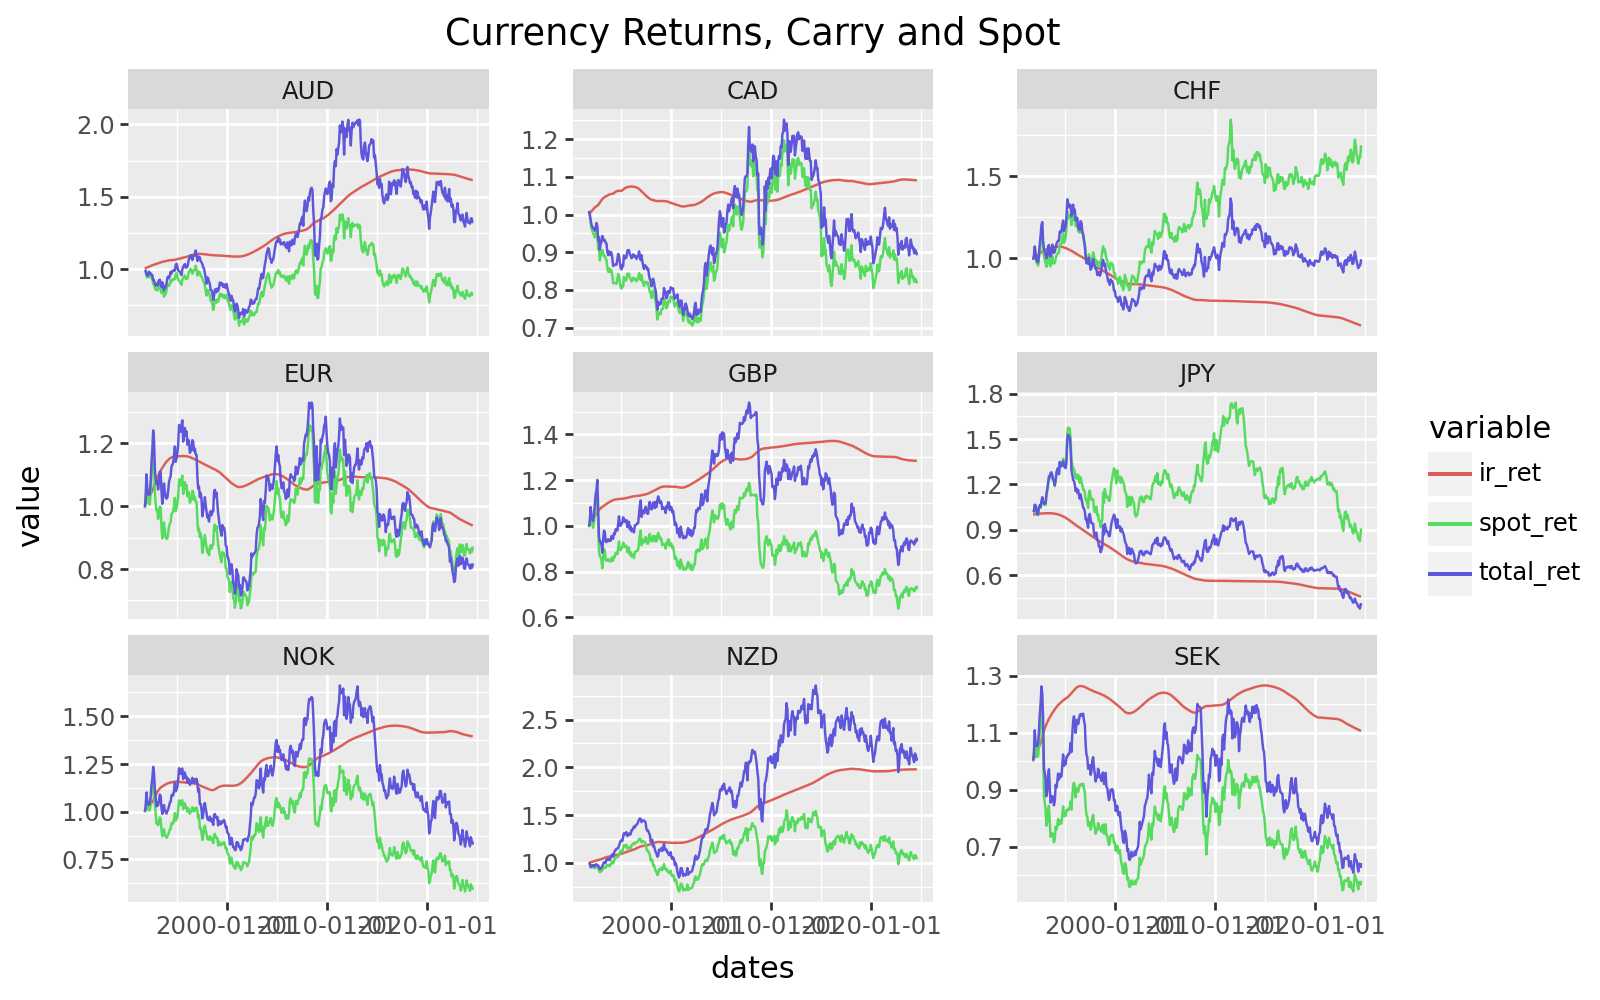

In [10]:
(
    data.drop_nulls().select('dates', 'ticker', 'total_ret', 'spot_ret', 'ir_ret')
    .unpivot(index=['dates', 'ticker'])
    .sort(by='dates')
    .pipe(p9.ggplot)
    + p9.aes(x='dates', y='value', color='variable')
    + p9.geom_line()
    + p9.facet_wrap('ticker', scales='free_y')
    + p9.ggtitle("Currency Returns, Carry and Spot")
)

## Mystery of UIP → What is the FX Carry Trade All About?

The real point of FX Carry trading is the UIP Problem.

In a nutshell: you are making money on the Interest Rate Return, as well as the Spot Return.

From an Rational Expectations point of view, which in Economic Speak means that Economic Agents are Rational, there should be no free lunch.  So whatever income you make from the Interest Rate differential, should be destroyed by the Sport Returns.

In the above chart:     
1. Interest Income is the Red Line
2. Spot Income is the Green Line.

Barring the 2008 debacle of the Carry Trade Exploding, in general the Red and the Blue Line move in line.

##### So the trading strategy is: borrow in low-yielding currencies, invest in high-yielding currencies
And you get the double whammy on Spot moving in your favour

## The Carry Factor and How to Trade It

Ignoring complex maths / linear-regressions, a factor approach really says:    
1. There is a relationship between interest rate differentials
2. Future currency returns
3. The reasons are not fully understood, though we have some wishy-washy reasons😁 (like people borrow cheap and lend expensive therefore driving prices of high-yielding currencies up.  The reason this doesn't fully explain it, is due the sporadic implosion of this trade, which tends to wipe out participants)

So the approach is: rank the interest differentials to the US Dollar at each time step, and plot out the PL resulting from investing in each of these ranked currencies

In [6]:
NUM_QUANTILES = 9
labels = [str(x) for x in range(NUM_QUANTILES)]

data_q = (
    data
    .drop_nulls()
    .with_columns(
        pl.col('ir_diff').qcut(quantiles=NUM_QUANTILES, labels=labels, allow_duplicates=True).over("dates").alias("ir_diff_q").cast(pl.UInt32)
    )
)

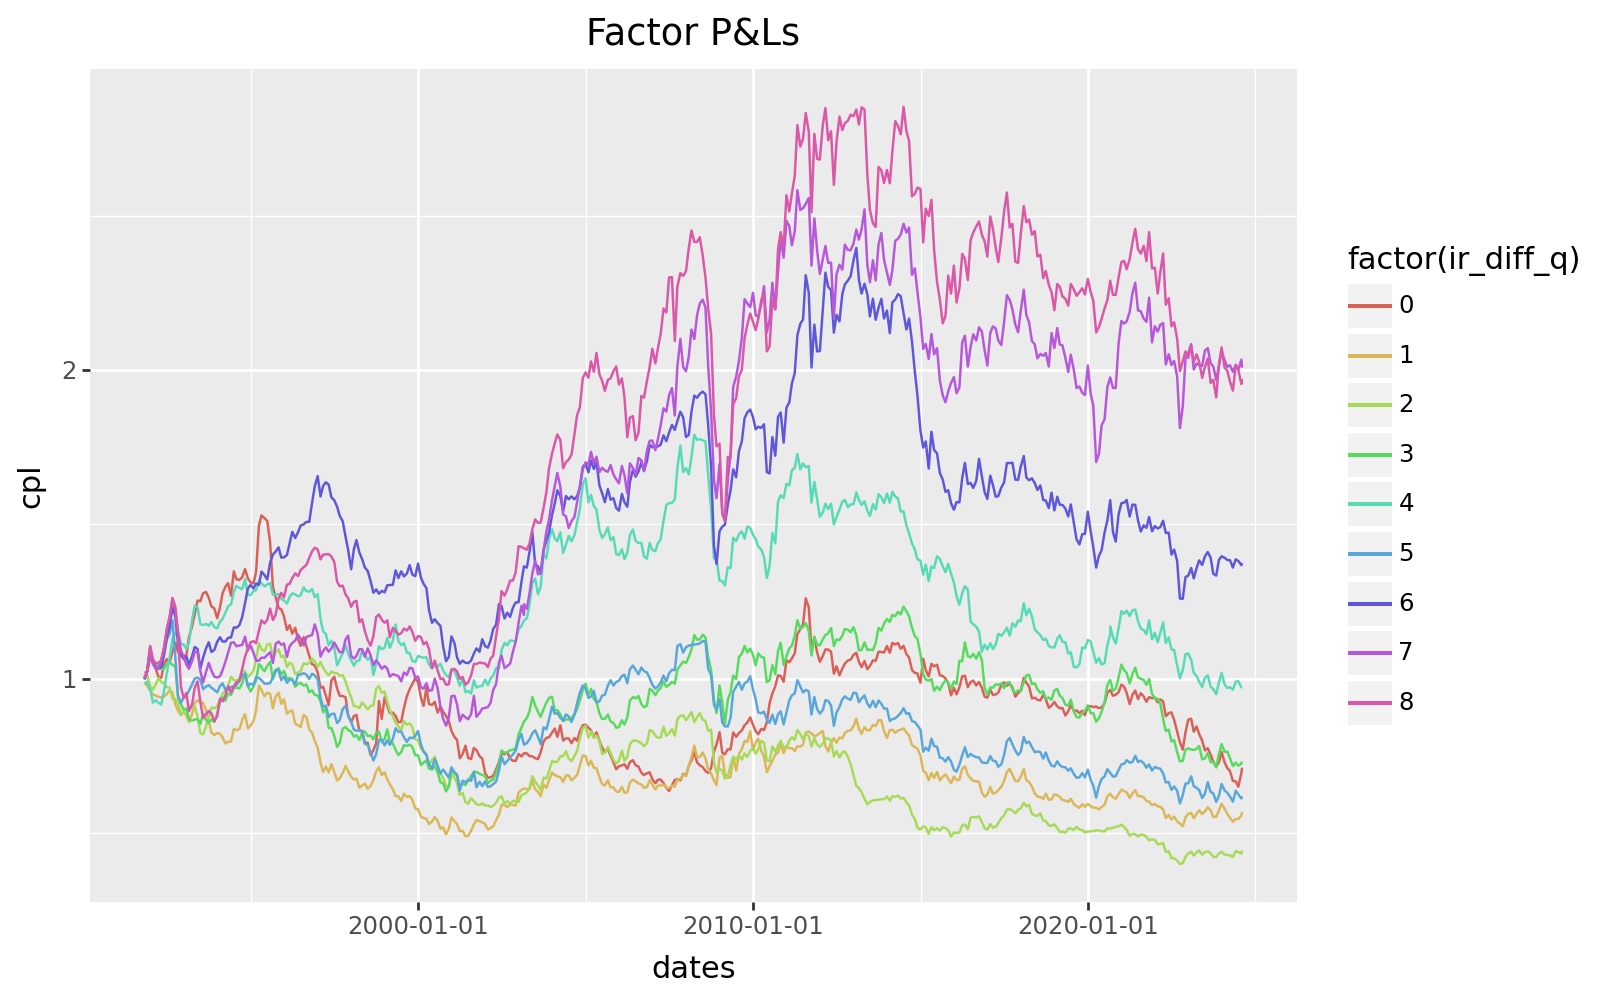

In [7]:
(
    data_q
    .drop_nulls()
    .select('dates', 'ir_diff_q', 'monthly_total_ret')
    .sort(by='dates')
    .group_by('ir_diff_q', maintain_order=True)
    .agg(
        pl.all(),
        (1 + pl.col('monthly_total_ret')).cum_prod().alias('cpl')
    )
    .explode(pl.exclude('ir_diff_q'))
    .select('dates', 'ir_diff_q', 'cpl')
    .pipe(p9.ggplot)
    + p9.aes(x='dates', y='cpl', color='factor(ir_diff_q)')
    + p9.geom_line()
    + p9.ggtitle('Factor P&Ls')
)

## A Factor Portfolio and Tradable Strategy: Go long the Strong Quantiles, and Short the Weak Quantiles, a la UIP

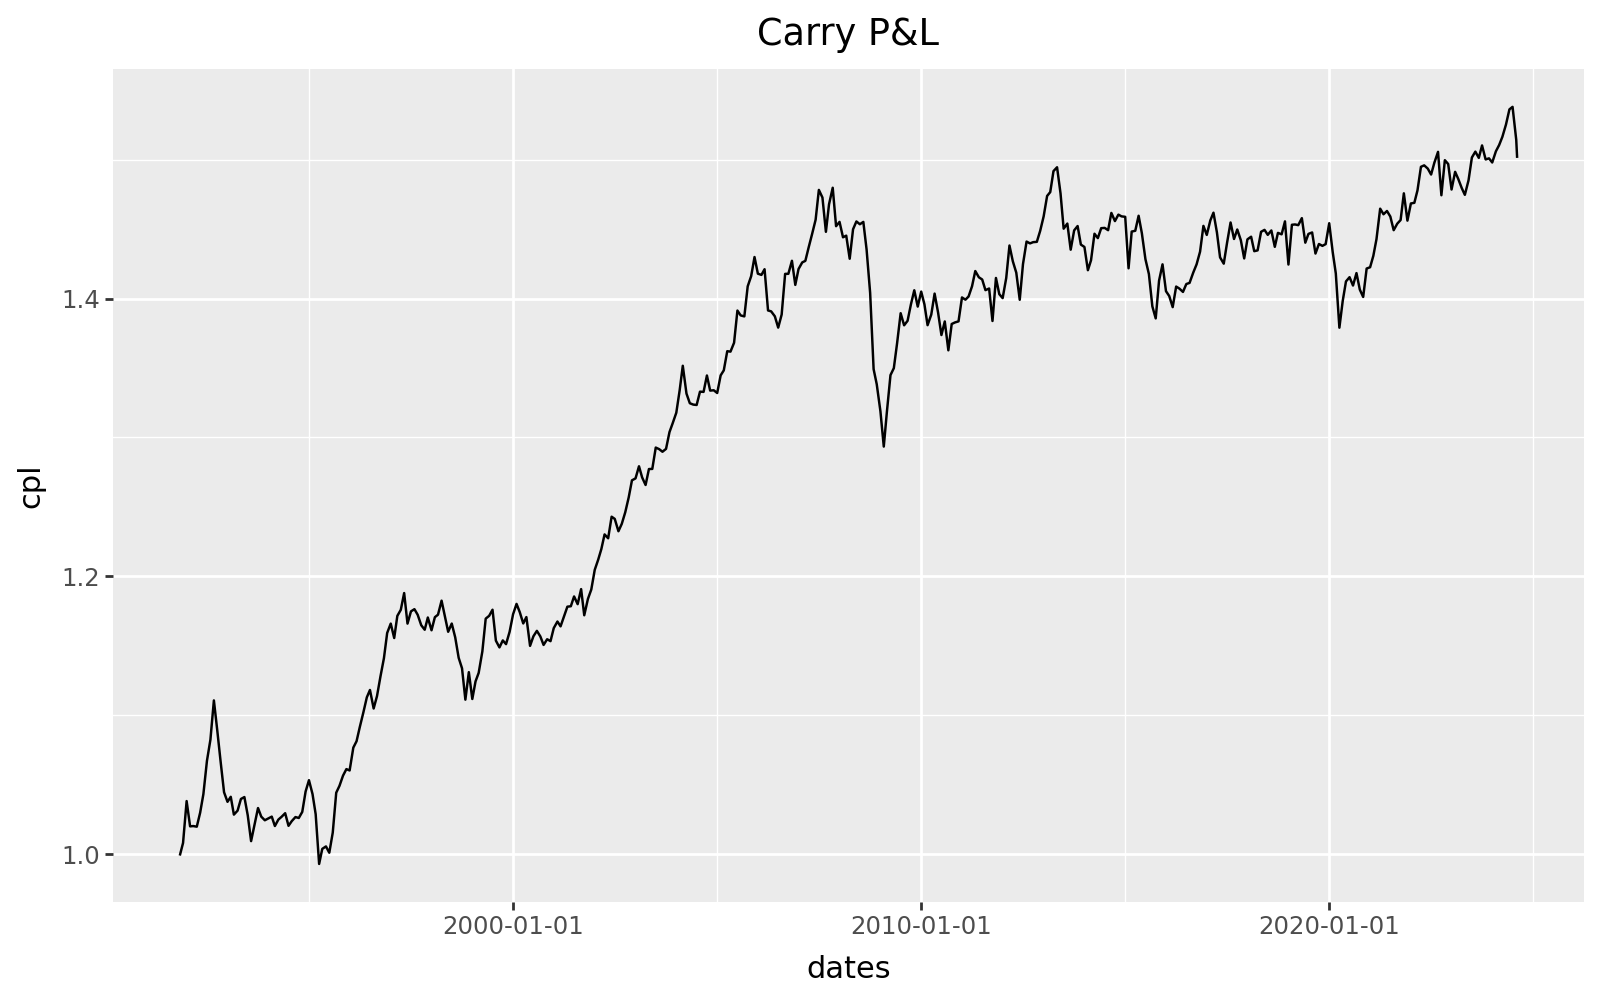

In [11]:
MID_QUANTILE = NUM_QUANTILES // 2
(
    data_q
    .with_columns(
        pl.when(pl.col('ir_diff_q') > MID_QUANTILE).then(1).when(pl.col('ir_diff_q') < MID_QUANTILE).then(-1).otherwise(0).alias('flag')
    )
    .with_columns(
        (pl.col('flag') * pl.col('monthly_total_ret')).alias('pl')
    )
    .drop_nulls()
    .group_by('dates' ,maintain_order=True)
    .agg(
        pl.col('pl').sum() / (NUM_QUANTILES - 1)
    )
    .with_columns(
        (1 + pl.col('pl')).cum_prod().alias('cpl')
    )
    .pipe(p9.ggplot)
    + p9.aes(x='dates', y='cpl')
    + p9.geom_line()
    + p9.ggtitle("Carry P&L")
)